# Real-time image style transfer

This code implements a simple TensorFlow-based deep learning image style transfer. It uses a pre-trained megenta model and the TensorFlow Hub library to transform camera-captured images into images with a specified style in real time.
### Reference
- https://tensorflow.google.cn/hub/tutorials/tf2_arbitrary_image_stylization?hl=zh-cn

- https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2

## Importing necessary libraries for plotting and image processing

In [2]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import cv2
import numpy as np
from IPython.display import display, Javascript
from IPython.display import HTML
from google.colab.output import eval_js
from base64 import b64decode
import io
from PIL import Image

from IPython.display import clear_output
from getpass import getpass

# Define image loading and visualization functions

In [3]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

331580/331580 [==============================] - 0s 0us/step


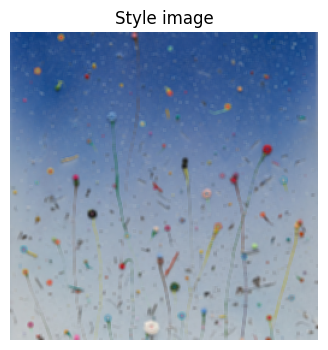

In [4]:
# @title Load example images  { display-mode: "form" }

# style image can be customized
style_image_url = 'https://images.squarespace-cdn.com/content/v1/5881f213a5790ac16d505983/1486549429319-3BHSRUYJO1TSUS5R2JEM/Silent-Winds-Avalon%2C-110x90cm%2C-2014-copie.jpg?format=1000w'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)

style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([style_image], ['Style image'])

In [5]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [6]:
# HTML code defining the video player used to capture the image
VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)

var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] =[video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

In [7]:
# Define functions for taking photos
# As Colab is in the cloud server, Colab cannot call the local laptop camera directly with opencv
# This code uses a method of acquiring camera images via JavaScript and HTML.
# A camera window is displayed using the display function and HTML code to allow the user to take a picture.
# Use JavaScript code to capture the camera image data and pass it to Python.
# Get the image data returned by the JavaScript code via eval_js("data").
# Decode and convert the image data to a NumPy array.
# Return the NumPy array representing the captured image.

def take_photo(filename='photo.jpg', quality=1.0, size=(400,300)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))


In [8]:
# Create a folder for saving images
save_folder = '/content/drive/MyDrive'  # Specify the path of the saved folder
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


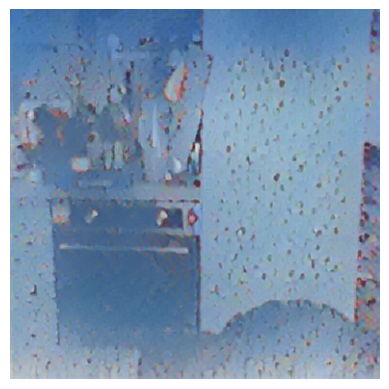

Press q to quit:··········


In [9]:
# Turn on the camera
cap=cv2.VideoCapture(0)

# Defining the counter
count = 0

while True:
    # Capture images
    content_img = take_photo()

    # Converting images to float32 arrays
    content_img = content_img.astype(np.float32) / 255.0

    # Image resizing and dimensionality
    content_img = tf.image.resize(content_img, content_img_size)
    content_img = tf.expand_dims(content_img, axis=0)

    # Image style conversion
    outputs = hub_module(content_img, tf.constant(style_image))
    stylized_image = outputs[0]

    # Display images
    plt.imshow(stylized_image[0])
    plt.axis('off')
    plt.show()

    # Save captured images and stylized images
    content_img_array = np.squeeze(content_img.numpy())  # Converting TensorFlow tensors to NumPy arrays
    stylized_img_array = np.squeeze(stylized_image.numpy())

    cv2.imwrite(os.path.join(save_folder, f'content_img_{count}.jpg'), content_img_array)
    cv2.imwrite(os.path.join(save_folder, f'stylized_image_{count}.jpg'), stylized_img_array)


    # Add counter
    count += 1

    # Check for key input
    try:
        key = getpass(prompt='Press q to quit:')
        if key == 'q':
            break
        clear_output(wait=True)
    except KeyboardInterrupt:
        break

# Release the camera and close the window
cap.release()
cv2.destroyAllWindows()






